In [1]:
pip install tensorflow-hub

Note: you may need to restart the kernel to use updated packages.


### Import necessary Libraries

In [4]:
import numpy as np
import pandas as pd
import cv2
import os
import tensorflow as tf
from tensorflow.keras.preprocessing.image import load_img, img_to_array,ImageDataGenerator
import matplotlib.pyplot as plt
import tensorflow_hub as hub
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import Input, GlobalAveragePooling2D, Dense, Flatten, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras import layers
from tensorflow.keras.callbacks import ModelCheckpoint
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report


# Load Data

In this part, we will load and preprocess the train, validation, anmd test data from their respective directory. Each data is loaded abnd preprocess using the `loadData` function.

img_size: specifies that all images will be resized to 224x224 pixels
batch_size: sets how many images will be processed at once (16 images per batch)

The `loadData` function has two parameters
`directory`: the path to the folder containing the images
`shuffle`: a boolean(true/false) flag to determine if we should randomize the data order

The `dataset` wwill automatically finds all images in the directory and assumes each subdirectory represents a different class.Then, it resizes images to the specified img size and groups the images into batches of size 16 and the label_mode will creates integer labels for each class.

We then store the names of the classes (taken from the subdirectory names) in the `class_names` 

the `preprocessImage` function is to converts the image to float32 format, ensure that the images are in the correct size, and normalizes or scales pixel values to be between 0 and 1 (dividing by 255)

Then, if the shuffle is True, it randomizes the order of images using a buffer of 100 images

the `processed_dataset` wwill apply the preprocessing function to all images and prefetches data to prevent input/output delay. `AUTOTUNE` will lets TensorFlow optimize the buffer size automatically.

In [2]:
img_size = (224, 224)
batch_size = 16
def loadData(directory, shuffle=False):
    # Load dataset
    dataset = tf.keras.utils.image_dataset_from_directory(
        directory,
        image_size=img_size,
        batch_size=batch_size,
        label_mode='int'
    )
    
    # Store class names
    class_names = dataset.class_names
    
    # Preprocess function
    def preprocessImage(image, label):
        # Convert to float32 and resize
        image = tf.cast(image, tf.float32)
        image = tf.image.resize(image, img_size)
        # Normalize to [0,1] range
        image = image / 255.0
        return image, label
    
    # Apply preprocessing and optimizations
    if shuffle:
        dataset = dataset.shuffle(buffer_size=100)
    
    processed_dataset = dataset.map(preprocessImage).cache().prefetch(buffer_size=tf.data.AUTOTUNE)
    
    return processed_dataset, class_names
  

In [5]:
# Load datasets from separate folders
train_data, class_names = loadData(r"C:\Users\kathl\Documents\plant data\train", shuffle=True)
val_data, _ = loadData(r"C:\Users\kathl\Documents\plant data\valid", shuffle=False)
test_data, _ = loadData(r"C:\Users\kathl\Documents\plant data\test", shuffle=False)

num_classes = len(class_names)
print("Class Names:"+ str(class_names))

Found 21600 files belonging to 36 classes.
Found 3960 files belonging to 36 classes.
Found 1980 files belonging to 36 classes.
Class Names:['Aloe Vera', 'Asthma Plant', 'Avocado', 'Bilimbi', 'Bitter Melon', 'Bougainvillea', 'Butterfly Pea', 'Calamondin', 'Candle Stick', 'Chili Pepper', 'Chinese Hibiscus', 'Chinese Violet', 'Coral Swirl', 'Golden Candle', 'Green Chiretta', 'Guava', 'Indian Acalypha', 'Indian Head Ginger', 'Insulin Plant', 'Jamaica Cherry', 'Malabar Spinach', 'Mango', 'Moringa', 'Opposite Laef Fig', 'Oregano', 'Papaya', 'Pomelo', 'Shame Plant', 'Shiny Bush', 'Soursop', 'Spiny Amaranth', 'Stone Breaker', 'Sweet Potato Leaves', 'Unknown', 'Weeping Bottlebrush', 'Wild Tea']


# Build the Model

The `mobilenet()` funtion builds a transfer learning model using MobileNetV2 as the base model. Firstly, it loads the pre-trained `MobileNetV2` model as the base with the parameters:
- input_shape that defines the input size for the model (224x224x3 for RGB images)
- include_top set to False to excludes the final fully connected layers of the pre-trained model, as we'll add our custom classification layers for the specific task.
- weights pre-trained on the ImageNet dataset.

Then, it will `freeze the base model` to prevent its weights from being updated during training and to ensures that the pre-trained features are retained and not overwritten. Next, it create a `Sequential` model to stack layers sequencially and then add the base model as the first layer. Then it adds a `global average pooling` layer to reduce the spatial dimensions of the feature maps and produce a single feature vector per image. `Dropout layer` was also added to reduce overfitting by randomly setting 25% of input units to 0 during training. `Overfitting` occurs when the model performs extremely well on the training data but fails to generalize to unseen data in validation and testing. The last layer is the `Dense layer` for classification with 'num_classes' units and it uses `softmax` activation for multi-class classification. Lastly, it returns the constructed model ready for training.

The model was compiled using `Adam Optimizer` with learning rate set to `0.001`, `sparse categorical crossentropy` as the loss funtion, and `accuracy` as the metrics to track accuracy during training and validation.

The model's summary shows the total number of parameters in the model. These parameters are learned during the training process and are essential to the model's ability to make predictions. The trainable parameters has 46,116 and these are the parameters that the model will learn during training. Since the base MobileNetV2 model is set to `trainable=False`, these parameters are frozen(Non-trainable) and do not get updated during training. They come from the pre-trained ImageNet weights.

In [7]:
# Build model
def mobilenet(num_classes):
    input_layer = Input(shape=(224, 224, 3))

    # Base MobileNetV2 model
    base_model = MobileNetV2(input_tensor=input_layer, include_top=False, weights='imagenet')
    base_model.trainable = False

    # Custom layer
    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dropout(0.25)(x)
    output_layer = Dense(num_classes, activation='softmax')(x)
    
    model = Model(inputs=input_layer, outputs=output_layer)
    return model

In [9]:
# Initialize the model
model = mobilenet(num_classes)
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),  loss=keras.losses.SparseCategoricalCrossentropy(), metrics=['accuracy'])
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1 (Conv2D)      │ (None, 112, 112,  │        864 │ input_layer[0][0] │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bn_Conv1            │ (None, 112, 112,  │        128 │ Conv1[0][0]       │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1_relu (ReLU)   │ (None, 112, 112,  │          0 │ bn_Conv1[0][0]    │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │        288 │ Conv1_relu[0][0]  │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │        128 │ expanded_conv_de… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │          0 │ expanded_conv_de… │
│ (ReLU)              │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 112, 112,  │        512 │ expanded_conv_de… │
│ (Conv2D)            │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 112, 112,  │         64 │ expanded_conv_pr… │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand      │ (None, 112, 112,  │      1,536 │ expanded_conv_pr… │
│ (Conv2D)            │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_BN   │ (None, 112, 112,  │        384 │ block_1_expand[0… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_relu │ (None, 112, 112,  │          0 │ block_1_expand_B… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_pad         │ (None, 113, 113,  │          0 │ block_1_expand_r… │
│ (ZeroPadding2D)     │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise   │ (None, 56, 56,    │        864 │ block_1_pad[0][0] │
│ (DepthwiseConv2D)   │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 56, 56,    │        384 │ block_1_depthwis… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 56, 56,    │          0 │ block_1_depthwis… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_project     │ (None, 56, 56,    │      2,304 │ block_1_depthwis

 Total params: 2,304,100 (8.79 MB)

 Trainable params: 46,116 (180.14 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

# Train the model
The `checkpoint` will automatically save the model with lowest validation loss during training.

The useful information about the training process, like the values of various metrics and losses for each epoch during training and validation, will be stored in the `history`, so that we can use it to plot graphs and visually analyze the model's learning behavior.

- train_batches: The training data batches.
- validation_batches: The validation data batches.
- epochs=15: The model was trained for 15 epochs, iterating through the entire training dataset 15 times.


In [6]:
checkpoint = ModelCheckpoint("best_model_Mobilenet.keras", monitor='val_loss', verbose=1, save_best_only=True, mode='min')

# Train the model with only checkpoint
history = model.fit(train_data, validation_data=val_data, epochs=15, callbacks=[checkpoint])

Epoch 1/15
1350/1350 ━━━━━━━━━━━━━━━━━━━━ 0s 337ms/step - accuracy: 0.5372 - loss: 1.7404
Epoch 1: val_loss improved from inf to 0.67172, saving model to best_model_Mobilenet.keras
1350/1350 ━━━━━━━━━━━━━━━━━━━━ 566s 409ms/step - accuracy: 0.5373 - loss: 1.7399 - val_accuracy: 0.8005 - val_loss: 0.6717
Epoch 2/15
1350/1350 ━━━━━━━━━━━━━━━━━━━━ 0s 288ms/step - accuracy: 0.8135 - loss: 0.6332
Epoch 2: val_loss improved from 0.67172 to 0.56763, saving model to best_model_Mobilenet.keras
1350/1350 ━━━━━━━━━━━━━━━━━━━━ 461s 342ms/step - accuracy: 0.8135 - loss: 0.6332 - val_accuracy: 0.8328 - val_loss: 0.5676
Epoch 3/15
1350/1350 ━━━━━━━━━━━━━━━━━━━━ 0s 293ms/step - accuracy: 0.8468 - loss: 0.5081
Epoch 3: val_loss improved from 0.56763 to 0.54902, saving model to best_model_Mobilenet.keras
1350/1350 ━━━━━━━━━━━━━━━━━━━━ 466s 345ms/step - accuracy: 0.8468 - loss: 0.5081 - val_accuracy: 0.8348 - val_loss: 0.5490
Epoch 4/15
1350/1350 ━━━━━━━━━━━━━━━━━━━━ 0s 289ms/step - accuracy: 0.8668 - los

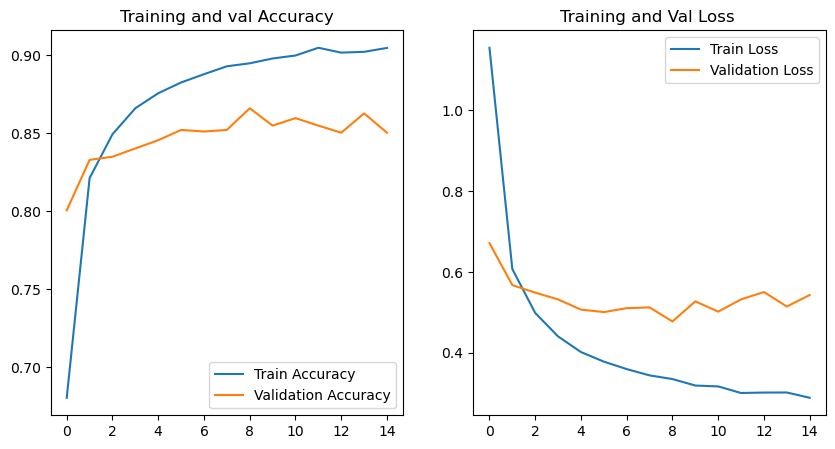

In [17]:
# Plot accuracy and loss
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and val Accuracy')

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Val Loss ')
plt.show()



# Test the model

In [7]:
# Load the saved trained model first
model= tf.keras.models.load_model('best_model_Mobilenet.keras')

124/124 ━━━━━━━━━━━━━━━━━━━━ 39s 300ms/step


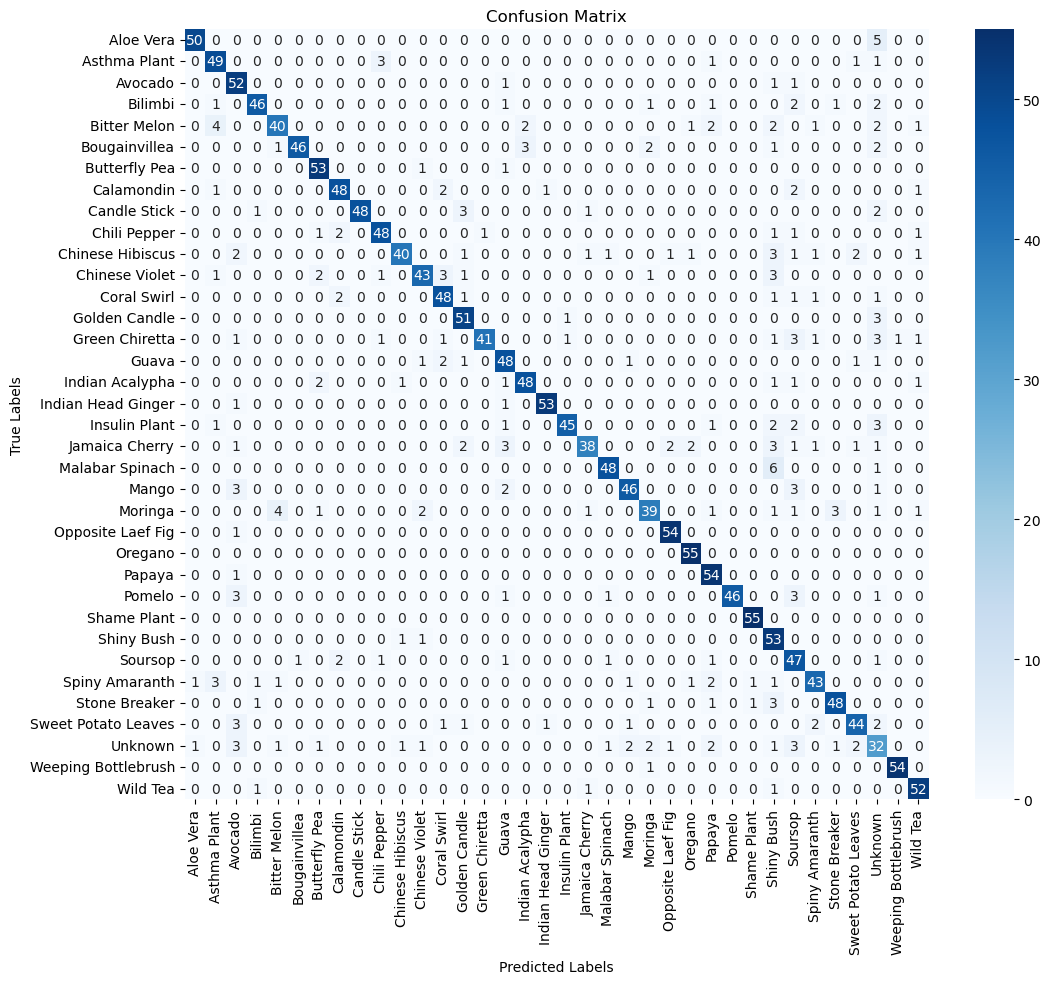

Classification result:
                     precision    recall  f1-score   support

          Aloe Vera       0.96      0.91      0.93        55
       Asthma Plant       0.82      0.89      0.85        55
            Avocado       0.73      0.95      0.83        55
            Bilimbi       0.92      0.84      0.88        55
       Bitter Melon       0.85      0.73      0.78        55
      Bougainvillea       0.98      0.84      0.90        55
      Butterfly Pea       0.88      0.96      0.92        55
         Calamondin       0.89      0.87      0.88        55
       Candle Stick       1.00      0.87      0.93        55
       Chili Pepper       0.89      0.87      0.88        55
   Chinese Hibiscus       0.93      0.73      0.82        55
     Chinese Violet       0.88      0.78      0.83        55
        Coral Swirl       0.84      0.87      0.86        55
      Golden Candle       0.84      0.93      0.88        55
     Green Chiretta       0.98      0.75      0.85        55


In [9]:
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report

# Get True Labels and Predictions
y_true = np.concatenate([labels.numpy() for _, labels in test_data])
y_pred_probs = model.predict(test_data)
y_pred = np.argmax(y_pred_probs, axis=1) 

#generate Confusion Matrix
cm = confusion_matrix(y_true, y_pred)

#visualize Confusion Matrix
plt.figure(figsize=(12, 10))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Confusion Matrix")
plt.show()

# Prnt Classification Report
result = classification_report(y_true, y_pred, target_names=class_names)
print("Classification result:")
print(result)


In [11]:
# Evaluate the model
test_loss, test_accuracy = model.evaluate(test_data)
print(f"Test Accuracy: {test_accuracy:.4f}")
print(f"Test Loss: {test_loss:.4f}")

124/124 ━━━━━━━━━━━━━━━━━━━━ 40s 291ms/step - accuracy: 0.8624 - loss: 0.4863
Test Accuracy: 0.8611
Test Loss: 0.4898


# Image Prediction with Confidence Thresholding

Confidence thresholding was added to better handle cases where the plant might not be medicinal. The threshold is set at 80%, so if the model isn't at least 80% confident in its prediction, it will label the plant as "Unknown."

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step


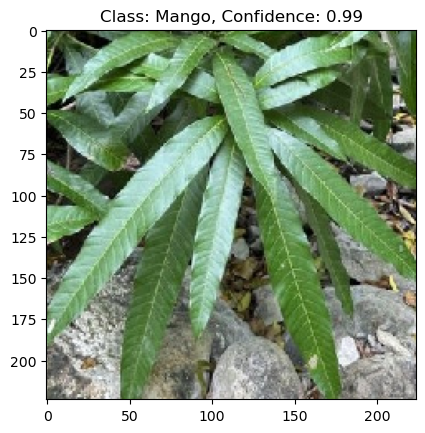

In [17]:
from tensorflow.keras.preprocessing.image import load_img, img_to_array

def pred(image_input):
    threshold = 0.8
    # load and preprocess the image
    img = load_img(image_input, target_size=(224, 224))  
    img_array = img_to_array(img) / 255.0
    img_array = np.expand_dims(img_array, axis=0) 
    # Model Prediction
    predictions = model.predict(img_array) 
    predicted_confidence = np.max(predictions) 
    predicted_class = np.argmax(predictions)
    
    # Check confidence threshold
    if predicted_confidence > threshold:
        result = f"Class: {class_names[predicted_class]}, Confidence: {predicted_confidence:.2f}"
    else:
        result = result = "Class: Unknown Plant",predicted_confidence
    #show the image with the prediction result
    plt.imshow(img)
    plt.title(result)
    plt.show()

pred(r"C:\Users\kathl\Documents\plant data\test\Mango\bd653e625320d720276cb1aebc881272.jpg")